# Setup

1. Get training data from Rayan Slim's Github. The data was collected by the simulator by manually driving the car three rounds forward and three backwards. **TODO:** Collect more training data for other tracks.
1. Download and import necessary libraries.
1. Check if CUDA is enabled. Unfortunately, I wasn't able to get this working locally, there seems to be some version compatibility error between my CUDA and CUDNN installations.

In [1]:
# Uncomment and run to get the training data
# !git clone --depth 1 https://github.com/rslim087a/track
# !ls track

In [2]:
# Common libraries
# !pip install scikit-learn numpy matplotlib pandas opencv-python

# PyTorch (non-GPU version, replace with 'torch' and 'torchvision' for GPU)
# !pip install --user torchvision # torch

# PyTorch with CUDA
# !pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu121

In [3]:
# import torch
# print(f'PyTorch version: {torch.__version__}')
# print('*'*10)
# print(f'_CUDA version: ')

# !nvcc --version
# print('*'*10)
# print(f'CUDNN version: {torch.backends.cudnn.version()}')
# print(f'Available GPU devices: {torch.cuda.device_count()}')
# print(f'Device Name: {torch.cuda.get_device_name()}')

In [4]:
import os
import random
import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as tvF
from torchvision.transforms.functional import gaussian_blur

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Preprocessing

First, we need to clean the paths such that they are accessible later on. The CSV log file was generated during data collection and as such has different paths as you can see below.

In [5]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,G:\drive\test_1\IMG\center_2024_05_12_02_00_41...,G:\drive\test_1\IMG\left_2024_05_12_02_00_41_4...,G:\drive\test_1\IMG\right_2024_05_12_02_00_41_...,0.0,0.000000,0.0,0.000042
1,G:\drive\test_1\IMG\center_2024_05_12_02_00_41...,G:\drive\test_1\IMG\left_2024_05_12_02_00_41_5...,G:\drive\test_1\IMG\right_2024_05_12_02_00_41_...,0.0,0.000000,0.0,0.000094
2,G:\drive\test_1\IMG\center_2024_05_12_02_00_41...,G:\drive\test_1\IMG\left_2024_05_12_02_00_41_6...,G:\drive\test_1\IMG\right_2024_05_12_02_00_41_...,0.0,0.110838,0.0,0.077475
3,G:\drive\test_1\IMG\center_2024_05_12_02_00_41...,G:\drive\test_1\IMG\left_2024_05_12_02_00_41_6...,G:\drive\test_1\IMG\right_2024_05_12_02_00_41_...,0.0,0.285562,0.0,0.189008
4,G:\drive\test_1\IMG\center_2024_05_12_02_00_41...,G:\drive\test_1\IMG\left_2024_05_12_02_00_41_7...,G:\drive\test_1\IMG\right_2024_05_12_02_00_41_...,0.0,0.516937,0.0,0.593286


In [6]:
def path_leaf(path):
    return path.split('\\')[-1]
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2024_05_12_02_00_41_487.jpg,left_2024_05_12_02_00_41_487.jpg,right_2024_05_12_02_00_41_487.jpg,0.0,0.000000,0.0,0.000042
1,center_2024_05_12_02_00_41_557.jpg,left_2024_05_12_02_00_41_557.jpg,right_2024_05_12_02_00_41_557.jpg,0.0,0.000000,0.0,0.000094
2,center_2024_05_12_02_00_41_626.jpg,left_2024_05_12_02_00_41_626.jpg,right_2024_05_12_02_00_41_626.jpg,0.0,0.110838,0.0,0.077475
3,center_2024_05_12_02_00_41_693.jpg,left_2024_05_12_02_00_41_693.jpg,right_2024_05_12_02_00_41_693.jpg,0.0,0.285562,0.0,0.189008
4,center_2024_05_12_02_00_41_760.jpg,left_2024_05_12_02_00_41_760.jpg,right_2024_05_12_02_00_41_760.jpg,0.0,0.516937,0.0,0.593286


Next, we plot a histogram of the steering angle values in the original dataset. Notice that the data follows a bell curve and that most values are 0.00. This is because the car was driven straight for most of the data collection phase, which is also the behavior we want when it learns to drive for itself.

array([-0.96, -0.88, -0.8 , -0.72, -0.64, -0.56, -0.48, -0.4 , -0.32,
       -0.24, -0.16, -0.08,  0.  ,  0.08,  0.16,  0.24,  0.32,  0.4 ,
        0.48,  0.56,  0.64,  0.72,  0.8 ,  0.88,  0.96])

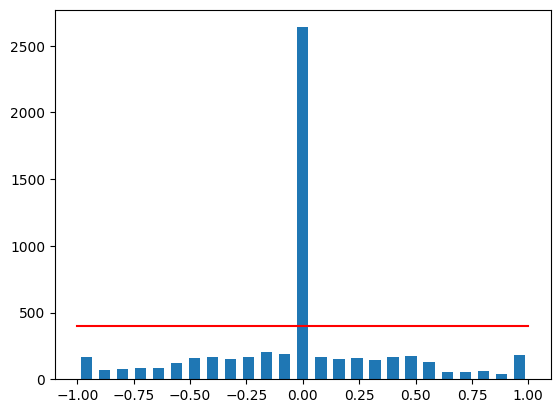

In [7]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin), color="red")
center

However, the presence of so many zeroes can drastically bias the car towards steering straight all the time instead of automatically making adjustments as required. Therefore, a `samples_per_bin` variable is initialized, which is used to specify the maximum number of samples each bin can have. Since every other bin has below 400 steering angle occurences, this will limit the zero values to 400. The red line denotes the cutoff. In the next code snippet, we get rid of the additional 0 values above 400.

Total data: 5769
Removed: 2238
Remaining: 3531


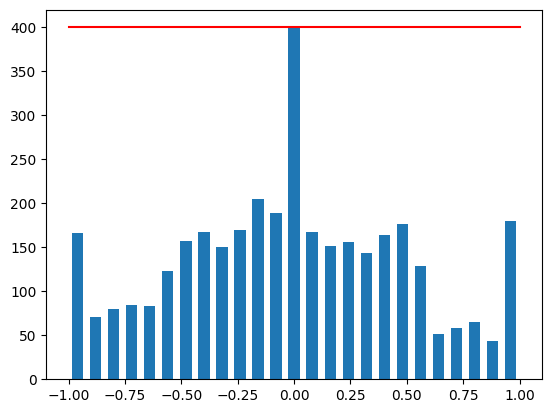

In [8]:
print('Total data:', len(data))

remove_list = []
for j in range(num_bins):
    # Filter the steering data between the current bin edges
    mask = (data['steering'] >= bins[j]) & (data['steering'] <= bins[j+1])
    filtered_indices = data[mask].index
    # Shuffle the filtered indices
    shuffled_indices = shuffle(filtered_indices, random_state=1)
    # Select the indices to remove
    remove_indices = shuffled_indices[samples_per_bin:]
    remove_list.extend(remove_indices)

print('Removed:', len(remove_list))
data.drop(index=remove_list, inplace=True)
print('Remaining:', len(data))

# Recalculate the histogram with the remaining data
hist, bin_edges = np.histogram(data['steering'], bins=num_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) * 0.5  # Compute the center of each bin
plt.bar(bin_centers, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin), color="red")
plt.show()

## Train-test split

Before performing the train-test split, we split the data into features (images) and targets (steering angles). This also helps us transform the data before training.

In [9]:
def load_img_steering(datadir, df):
    '''
    Load images and steering data into arrays.
    '''
    image_path = []
    steering = []
    adjustment = 0# Define the steering angle adjustment for left and right images

    for center, left, right, steer in zip(df['center'], df['left'], df['right'], df['steering']):
        # Center image and steering
        image_path.append(str(os.path.join(datadir, 'IMG', center.strip())))
        steering.append(float(steer))
        
        # Left image and adjusted steering
        image_path.append(str(os.path.join(datadir, 'IMG', left.strip())))
        steering.append(float(steer) - adjustment)

        # Right image and adjusted steering
        image_path.append(str(os.path.join(datadir, 'IMG', right.strip())))
        steering.append(float(steer) + adjustment)

    image_paths = np.asarray(image_path, dtype=str)
    steerings = np.asarray(steering, dtype=np.float32) # NOTE: Was float64
    return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir, data)
print(image_paths[0], steerings[0])

track\IMG\center_2024_05_12_02_00_41_760.jpg 0.0


Training Samples: 8474
Validation Samples: 2119


Text(0.5, 1.0, 'Validation set')

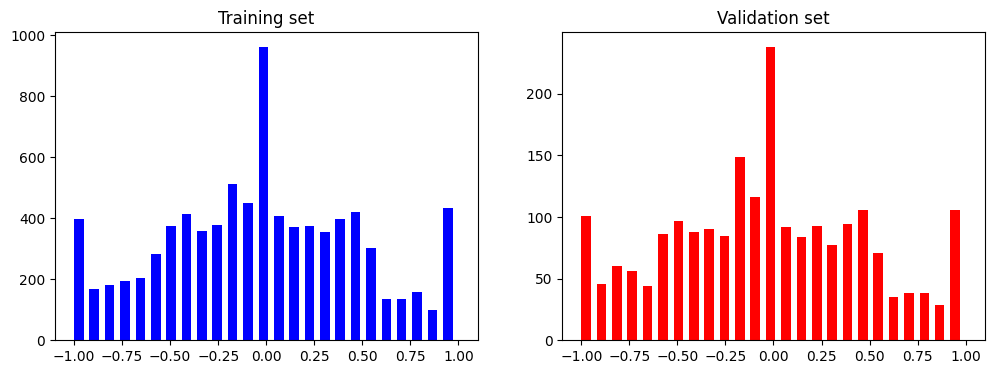

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValidation Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

# Create Datasets and DataLoaders

Now, we define some custom transformations to apply on the images prior to training and also a custom Dataset class for the dataset. The images are augmented in order to avoid overfitting the data, enabling the model to generalize better.

In [11]:
def rgb_to_ycbcr(image: torch.Tensor) -> torch.Tensor:
    r"""Convert an RGB image to YCbCr.

    Args:
        image (torch.Tensor): RGB Image to be converted to YCbCr.

    Returns:
        torch.Tensor: YCbCr version of the image.
    """

    if not torch.is_tensor(image):
        raise TypeError("Input type is not a torch.Tensor. Got {}".format(
            type(image)))

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError("Input size must have a shape of (*, 3, H, W). Got {}"
                         .format(image.shape))

    r: torch.Tensor = image[..., 0, :, :]
    g: torch.Tensor = image[..., 1, :, :]
    b: torch.Tensor = image[..., 2, :, :]

    delta = .5
    y: torch.Tensor = .299 * r + .587 * g + .114 * b
    cb: torch.Tensor = (b - y) * .564 + delta
    cr: torch.Tensor = (r - y) * .713 + delta
    return torch.stack((y, cb, cr), -3)

def img_preprocess_tensor(img_tensor):
    '''
    Preprocess the image by cropping, converting to YCbCr, applying Gaussian blur, and resizing.
    '''
    # Assuming img_tensor is a PyTorch tensor in (C, H, W) format
    # Crop
    img_tensor = img_tensor[:, 60:135, :]
    
    # Convert color space if needed - this would require custom implementation or prior conversion
    img_tensor = rgb_to_ycbcr(img_tensor)

    # Apply Gaussian blur
    img_tensor = gaussian_blur(img_tensor, kernel_size=[3, 3])
    
    # Resize
    img_tensor = transforms.Resize((66, 200))(img_tensor)
    
    return img_tensor

'''
Custom transformation class to apply random affine transformation, 
horizontal flip, and random change in brightness to the input image.

Note: We need to write this because we also need to update the
steering angle value associated with the image. This also makes it
much easier to dynamically add or remove transformations as needed.
'''
class TransformBoth:
    def __init__(self, flip_prob=0.5, affine_scale=(1, 1.3), translate=(0.1, 0.1)):
        self.flip_prob = flip_prob
        self.affine_scale = affine_scale
        self.translate = translate

    def __call__(self, image, steering: float) -> Tuple[torch.Tensor, float] :
        # Convert numpy array or a torch tensor to PIL Image if not already
        # image = F.to_pil_image(image)

        # Apply random affine transformation with zoom and translation
        width, height = image.size
        max_dx = self.translate[0] * width
        max_dy = self.translate[1] * height
        translations = (np.random.uniform(-max_dx, max_dx), np.random.uniform(-max_dy, max_dy))
        
        scale = random.uniform(*self.affine_scale)
        image = tvF.affine(image, angle=0, translate=translations, scale=scale, shear=0)
        original_steering = steering
        
        flipped = False

        # Apply random horizontal flip
        if random.random() < self.flip_prob:
            image = tvF.hflip(image)

            # Invert the steering angle too
            steering = float(-1 * steering)
            flipped = True

        # Apply random change in brightness

        # Convert PIL Image back to tensor
        image = tvF.to_tensor(image)
        
        # Some sanity checking because I was getting errors with data types
        if flipped:
            assert original_steering == -1 * steering

        return image, steering

class MyDrivingDataset(Dataset):
    def __init__(self, image_paths, steering_angles, transform=None):
        self.image_paths = image_paths
        self.steering_angles = steering_angles
        self.transform = transform
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        steering_angle = self.steering_angles[idx]

        if self.transform:
            image, steering_angle = self.transform(image, steering_angle)
            
         # Check if image is a PIL Image, convert to tensor if so
        if isinstance(image, Image.Image):
            image = self.to_tensor(image)
            
        # Some more preprocessing which will also be applied during inference
        image = img_preprocess_tensor(image)

        return image, np.float32(steering_angle)

Transformed image shape:  torch.Size([3, 66, 200])
Transformed image data type:  torch.float32
Transformed image minimum and maximum values:  tensor(0.0830) tensor(0.9717)
Transformed steering angle data type:  float32


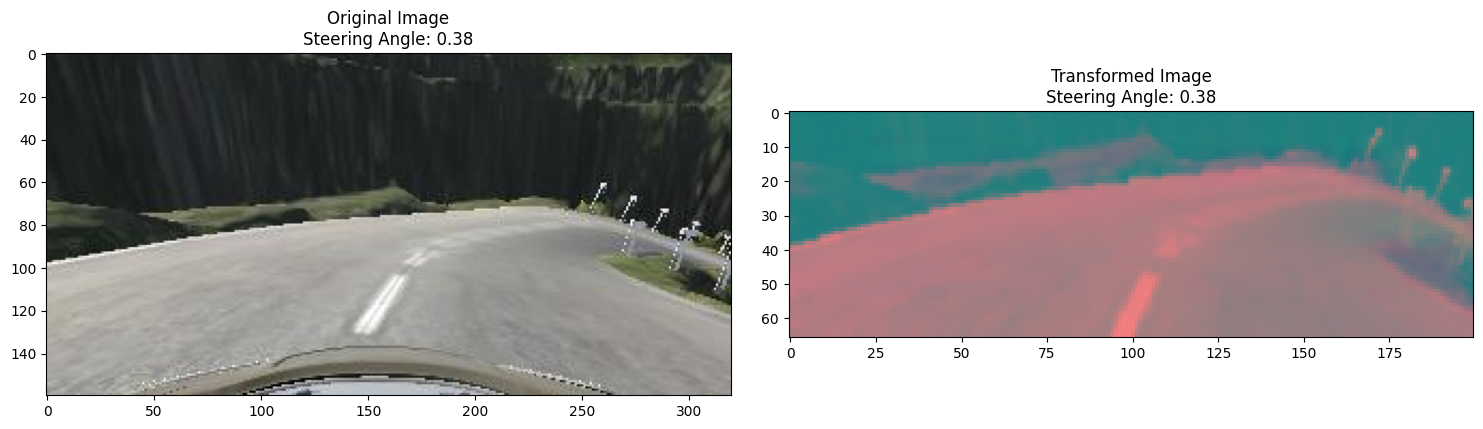

In [12]:
# Test the dataset and transformations
transform_both = TransformBoth()
dataset = MyDrivingDataset(image_paths, steerings, transform=transform_both)

idx = random.randint(0, 1000)
original_image = mpimg.imread(image_paths[idx])
original_steering = steerings[idx]

transformed_image, transformed_steering = dataset[idx]

print("Transformed image shape: ", transformed_image.shape)
print("Transformed image data type: ", transformed_image.dtype)
print("Transformed image minimum and maximum values: ", transformed_image.min(), transformed_image.max())
print("Transformed steering angle data type: ", transformed_steering.dtype)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image\nSteering Angle: {:.2f}'.format(original_steering))

axs[1].imshow(transformed_image.permute(1, 2, 0))
axs[1].set_title('Transformed Image\nSteering Angle: {:.2f}'.format(transformed_steering))

plt.show()

In [34]:
# Define the DataLoaders
batch_size = 64

train_dataset = MyDrivingDataset(X_train, y_train, transform=TransformBoth())
valid_dataset = MyDrivingDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Model definition and training

Finally, we define the model, followed by the training loop. The model defined below is the NVIDIA DAVE-2 model, as described in the README.md.

In [56]:
class DAVE2Model(nn.Module):
    def __init__(self):
        super(DAVE2Model, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.Dropout(0.5)
        )
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 6 * 3, 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.Linear(10, 1)
        )
        
        self.float()
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x) 
        x = self.fc_layers(x)
        return x
model = DAVE2Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay = 1e-6)
criterion = nn.MSELoss()

Epoch 1/30, Train Loss: 0.0498, Valid Loss: 0.0428
Epoch 2/30, Train Loss: 0.0415, Valid Loss: 0.0281
Epoch 3/30, Train Loss: 0.0328, Valid Loss: 0.0245
Epoch 4/30, Train Loss: 0.0297, Valid Loss: 0.0247
Epoch 5/30, Train Loss: 0.0285, Valid Loss: 0.0218
Epoch 6/30, Train Loss: 0.0276, Valid Loss: 0.0231
Epoch 7/30, Train Loss: 0.0263, Valid Loss: 0.0222
Epoch 8/30, Train Loss: 0.0269, Valid Loss: 0.0225
Epoch 9/30, Train Loss: 0.0270, Valid Loss: 0.0219
Epoch 10/30, Train Loss: 0.0265, Valid Loss: 0.0221
Epoch 11/30, Train Loss: 0.0252, Valid Loss: 0.0213
Epoch 12/30, Train Loss: 0.0246, Valid Loss: 0.0213
Epoch 13/30, Train Loss: 0.0253, Valid Loss: 0.0211
Epoch 14/30, Train Loss: 0.0241, Valid Loss: 0.0207
Epoch 15/30, Train Loss: 0.0241, Valid Loss: 0.0202
Epoch 16/30, Train Loss: 0.0232, Valid Loss: 0.0211
Epoch 17/30, Train Loss: 0.0236, Valid Loss: 0.0198
Epoch 18/30, Train Loss: 0.0247, Valid Loss: 0.0221
Epoch 19/30, Train Loss: 0.0236, Valid Loss: 0.0203
Epoch 20/30, Train Lo

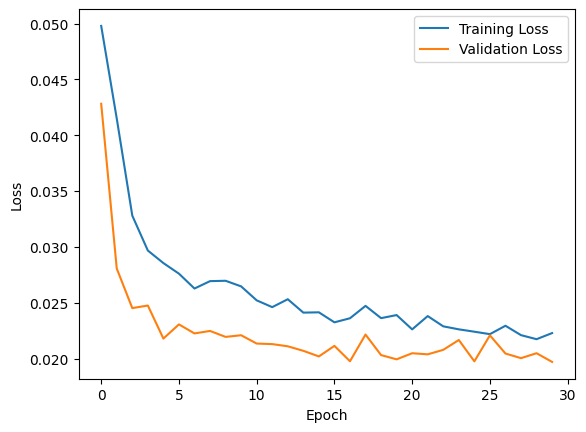

Best model saved. Best validation loss: 0.0197 at epoch 30.


In [57]:

import torch
import matplotlib.pyplot as plt

n_epochs = 30
train_losses = []
valid_losses = []
best_valid_loss = float('inf')  # Initialize with a large value
best_epoch = -1

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

    # Check if this epoch has the best validation loss so far
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_epoch = epoch
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f"Best model saved. Best validation loss: {best_valid_loss:.4f} at epoch {best_epoch+1}.")


In [48]:
torch.save(model.state_dict(), f'model_dave_2_ba{n_epochs}_epochs.pth')

Now that we have trained the model, we can test it out in the simulator using the `drive_pt.py` script!

**NOTE:** Be sure to include the same model definition in `model.py` as you defined above.